# 07 — Post-hoc Probability Calibration (USD/CAD, h=7)

Goal
- Improve probability calibration of directional models (p(UP)) using strictly out-of-sample calibration.
- Preserve the existing backtest protocol (expanding-window monthly refit).
- Evaluate calibration impact on:
  - logloss, Brier, ECE
  - reliability curves
  - decision-layer behavior (coverage vs metrics) using calibrated probabilities

Inputs
- outputs/usdcad_features_h7.parquet  (from Notebook 03)

Outputs (written to outputs/, ignored by git)
- calibrated_predictions_h7.parquet
- calibration_metrics_overall.csv
- calibration_reliability_bins.csv
- calibration_policy_sweep.csv


In [15]:
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import log_loss, brier_score_loss

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

RANDOM_SEED = 7
np.random.seed(RANDOM_SEED)

def find_repo_root(start: Path | None = None) -> Path:
    if start is None:
        start = Path.cwd()
    start = start.resolve()
    for p in [start] + list(start.parents):
        if (p / "README.md").exists() and (p / "notebooks").exists():
            return p
    return start

REPO_ROOT = find_repo_root()
OUT_DIR = REPO_ROOT / "outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

H = 7
FEATURE_PATH = OUT_DIR / f"usdcad_features_h{H}.parquet"
if not FEATURE_PATH.exists():
    raise FileNotFoundError(f"Feature parquet not found: {FEATURE_PATH}. Run Notebook 03 first.")

PRED_CAL_PATH = OUT_DIR / f"calibrated_predictions_h{H}.parquet"
METRICS_CSV = OUT_DIR / "calibration_metrics_overall.csv"
RELIAB_CSV = OUT_DIR / "calibration_reliability_bins.csv"
POLICY_SWEEP_CSV = OUT_DIR / "calibration_policy_sweep.csv"


In [16]:
df_feat = pd.read_parquet(FEATURE_PATH).sort_index()

target_col = f"direction_{H}d"
excluded = {target_col, f"fwd_return_{H}d"}
feature_cols = [c for c in df_feat.columns if c not in excluded]

X_all = df_feat[feature_cols].copy()
y_all = df_feat[target_col].astype(int).copy()

df_feat.shape, len(feature_cols)


((1960, 23), 21)

## Calibration protocol (strictly out-of-sample)

For each monthly test block:
1) Define training data = all dates strictly before the month.
2) Create a calibration window from the *end of training* (e.g., last 252 business days).
3) Fit base model on (training minus calibration window).
4) Predict probabilities on the calibration window.
5) Fit a calibrator using (p_raw, y_true) from the calibration window.
6) Refit base model on *full training* and produce p_raw for the test month.
7) Apply calibrator to test-month probabilities to get p_cal.

This avoids using in-sample probabilities for calibration and prevents leakage into the test month.


In [17]:
def expected_calibration_error(y_true: np.ndarray, p_up: np.ndarray, n_bins: int = 10) -> float:
    y_true = y_true.astype(int)
    p_up = np.asarray(p_up)

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ids = np.digitize(p_up, bins) - 1
    ids = np.clip(ids, 0, n_bins - 1)

    ece = 0.0
    n = len(p_up)
    for b in range(n_bins):
        mask = ids == b
        if not mask.any():
            continue
        frac = mask.mean()
        acc = y_true[mask].mean()
        conf = p_up[mask].mean()
        ece += frac * abs(acc - conf)
    return float(ece)

def reliability_bins(y_true: np.ndarray, p_up: np.ndarray, n_bins: int = 10) -> pd.DataFrame:
    y_true = y_true.astype(int)
    p_up = np.asarray(p_up)

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ids = np.digitize(p_up, bins) - 1
    ids = np.clip(ids, 0, n_bins - 1)

    rows = []
    for b in range(n_bins):
        mask = ids == b
        lo, hi = bins[b], bins[b + 1]
        if not mask.any():
            rows.append({"bin": b, "p_lo": lo, "p_hi": hi, "n": 0, "p_mean": np.nan, "y_mean": np.nan})
            continue
        rows.append({
            "bin": b,
            "p_lo": lo,
            "p_hi": hi,
            "n": int(mask.sum()),
            "p_mean": float(p_up[mask].mean()),
            "y_mean": float(y_true[mask].mean()),
        })
    return pd.DataFrame(rows)

def overall_prob_metrics(y_true: np.ndarray, p_up: np.ndarray) -> dict:
    y_true = y_true.astype(int)
    p_up = np.clip(np.asarray(p_up), 1e-6, 1 - 1e-6)
    return {
        "logloss": float(log_loss(y_true, np.c_[1 - p_up, p_up], labels=[0, 1])),
        "brier": float(brier_score_loss(y_true, p_up)),
        "ece_10": float(expected_calibration_error(y_true, p_up, n_bins=10)),
        "ece_20": float(expected_calibration_error(y_true, p_up, n_bins=20)),
    }


In [18]:
logreg_base = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegression(
        penalty="l2",
        C=1.0,
        solver="lbfgs",
        max_iter=2000,
        random_state=RANDOM_SEED
    ))
])

tree_base = HistGradientBoostingClassifier(
    max_depth=3,
    learning_rate=0.05,
    max_iter=300,
    min_samples_leaf=20,
    random_state=RANDOM_SEED
)


In [19]:
class IsotonicCalibrator:
    def __init__(self):
        self.iso = None

    def fit(self, p: np.ndarray, y: np.ndarray):
        p = np.asarray(p)
        y = np.asarray(y).astype(int)
        self.iso = IsotonicRegression(out_of_bounds="clip")
        self.iso.fit(p, y)
        return self

    def transform(self, p: np.ndarray) -> np.ndarray:
        p = np.asarray(p)
        if self.iso is None:
            return p
        return self.iso.transform(p)

def fit_calibrator_isotonic(p_cal: np.ndarray, y_cal: np.ndarray, min_size: int = 200) -> IsotonicCalibrator:
    if len(p_cal) < min_size:
        return IsotonicCalibrator()  # identity
    if len(np.unique(y_cal)) < 2:
        return IsotonicCalibrator()  # identity
    return IsotonicCalibrator().fit(p_cal, y_cal)


In [20]:
def calibrated_monthly_backtest(
    X: pd.DataFrame,
    y: pd.Series,
    base_model,
    cal_window: int = 252,
    min_train_size: int = 252 * 2,
    min_cal_size: int = 200,
) -> pd.DataFrame:
    idx = X.index
    months = pd.Series(idx.to_period("M"), index=idx)

    out_rows = []
    for m in months.unique():
        test_mask = months == m
        train_mask = months < m

        if train_mask.sum() < min_train_size:
            continue

        X_train_full = X.loc[train_mask]
        y_train_full = y.loc[train_mask]

        # calibration window = last `cal_window` rows of training (or all if smaller)
        cal_n = min(cal_window, len(X_train_full))
        X_cal = X_train_full.iloc[-cal_n:]
        y_cal = y_train_full.iloc[-cal_n:]

        # model-fit window = training excluding calibration window
        X_fit = X_train_full.iloc[:-cal_n] if len(X_train_full) > cal_n else X_train_full.iloc[:0]
        y_fit = y_train_full.iloc[:-cal_n] if len(y_train_full) > cal_n else y_train_full.iloc[:0]

        # if fit window too small, fall back to fitting on full train and calibrate on train tail (still OOS for test month)
        if len(X_fit) < min_train_size // 2:
            X_fit = X_train_full
            y_fit = y_train_full

        # 1) fit base model on X_fit, then get calibration probabilities on X_cal
        model1 = base_model
        model1.fit(X_fit, y_fit)
        p_cal_raw = model1.predict_proba(X_cal)[:, 1]

        # 2) fit calibrator on (p_cal_raw, y_cal)
        calibrator = fit_calibrator_isotonic(p_cal_raw, y_cal.values, min_size=min_cal_size)

        # 3) refit base model on full train and predict on test month
        model2 = base_model
        model2.fit(X_train_full, y_train_full)

        X_test = X.loc[test_mask]
        y_test = y.loc[test_mask].astype(int)

        p_test_raw = model2.predict_proba(X_test)[:, 1]
        p_test_cal = calibrator.transform(p_test_raw)

        block = pd.DataFrame(
            {
                "y_true": y_test.values,
                "p_raw": p_test_raw,
                "p_cal": p_test_cal,
                "train_end_month": str(m),
                "cal_size": int(len(X_cal)),
            },
            index=X_test.index,
        )
        out_rows.append(block)

    return pd.concat(out_rows).sort_index() if out_rows else pd.DataFrame()


In [21]:
bt_lr = calibrated_monthly_backtest(X_all, y_all, base_model=logreg_base, cal_window=252, min_cal_size=200)
bt_tr = calibrated_monthly_backtest(X_all, y_all, base_model=tree_base, cal_window=252, min_cal_size=200)

df_pred = bt_lr.rename(columns={"p_raw": "p_raw_logreg", "p_cal": "p_cal_logreg"})[["y_true", "p_raw_logreg", "p_cal_logreg"]].join(
    bt_tr.rename(columns={"p_raw": "p_raw_tree", "p_cal": "p_cal_tree"})[["p_raw_tree", "p_cal_tree"]],
    how="inner",
)

# attach regime flags if present (reuse from features)
for col in ["is_high_vol", "day_of_week", "month", "is_month_end"]:
    if col in df_feat.columns:
        df_pred[col] = df_feat.loc[df_pred.index, col]

df_pred.head(), df_pred.shape


df_pred.to_parquet(PRED_CAL_PATH, index=True)


/Users/ianvicente/Desktop/FX-Rate-Forecasting-Pipeline/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/ianvicente/Desktop/FX-Rate-Forecasting-Pipeline/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/ianvicente/Desktop/FX-Rate-Forecasting-Pipeline/.venv/lib/python3.12/site-packages/sklearn/linear_model/_

## Evaluation

We evaluate probability quality before vs after calibration:
- Overall: logloss, Brier, ECE (10/20 bins)
- Reliability bins (for plotting and inspection)
- Decision-layer impact: coverage tradeoffs using calibrated probabilities

Important: calibration should primarily improve probability metrics (ECE/Brier/logloss).
Directional accuracy may not change much, and that is expected.


In [22]:
rows = []
for model in ["logreg", "tree"]:
    for kind in ["raw", "cal"]:
        p = df_pred[f"p_{kind}_{model}"].values
        y = df_pred["y_true"].values
        m = overall_prob_metrics(y, p)
        m.update({"model": model, "variant": kind, "n": int(len(y))})
        rows.append(m)

df_metrics = pd.DataFrame(rows).sort_values(["model", "variant"]).reset_index(drop=True)
df_metrics.to_csv(METRICS_CSV, index=False)
df_metrics


,logloss,brier,ece_10,ece_20,model,variant,n
0,1.220187,0.285842,0.156047,0.156129,logreg,cal,1442
1,0.733935,0.264894,0.079327,0.087585,logreg,raw,1442
2,1.135056,0.279408,0.144390,0.148176,tree,cal,1442
3,0.896609,0.309484,0.198643,0.206686,tree,raw,1442


In [23]:
rel_rows = []
for model in ["logreg", "tree"]:
    for kind in ["raw", "cal"]:
        p = df_pred[f"p_{kind}_{model}"].values
        y = df_pred["y_true"].values
        rel = reliability_bins(y, p, n_bins=10)
        rel["model"] = model
        rel["variant"] = kind
        rel_rows.append(rel)

df_rel = pd.concat(rel_rows, ignore_index=True)
df_rel.to_csv(RELIAB_CSV, index=False)
df_rel.head(20)


,bin,p_lo,p_hi,n,p_mean,y_mean,model,variant
0,0,0.0,0.1,13,0.023751,0.461538,logreg,raw
1,1,0.1,0.2,11,0.151660,0.363636,logreg,raw
2,2,0.2,0.3,57,0.267167,0.438596,logreg,raw
3,3,0.3,0.4,236,0.356521,0.415254,logreg,raw
4,4,0.4,0.5,459,0.455110,0.505447,logreg,raw
5,5,0.5,0.6,411,0.542556,0.549878,logreg,raw
6,6,0.6,0.7,129,0.638559,0.627907,logreg,raw
7,7,0.7,0.8,79,0.751421,0.329114,logreg,raw
8,8,0.8,0.9,42,0.840718,0.404762,logreg,raw
9,9,0.9,1.0,5,0.914579,0.200000,logreg,raw


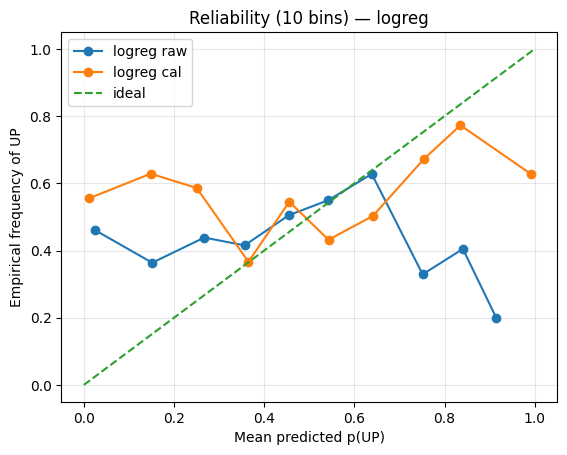

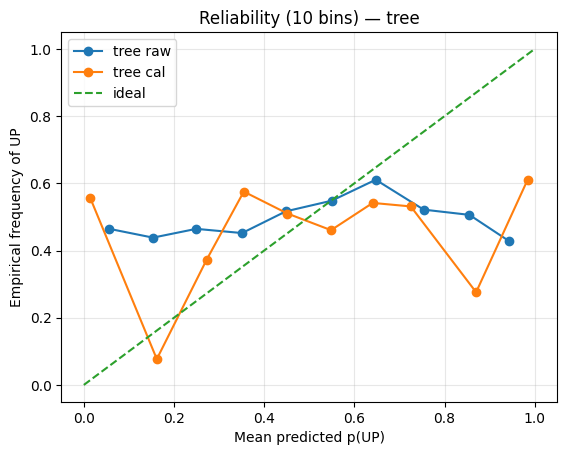

In [24]:
import matplotlib.pyplot as plt

def plot_reliability(df_rel: pd.DataFrame, model: str):
    plt.figure()
    for variant in ["raw", "cal"]:
        sub = df_rel[(df_rel["model"] == model) & (df_rel["variant"] == variant)].copy()
        sub = sub[sub["n"] > 0]
        plt.plot(sub["p_mean"], sub["y_mean"], marker="o", label=f"{model} {variant}")

    # diagonal
    xs = np.linspace(0, 1, 11)
    plt.plot(xs, xs, linestyle="--", label="ideal")

    plt.xlabel("Mean predicted p(UP)")
    plt.ylabel("Empirical frequency of UP")
    plt.title(f"Reliability (10 bins) — {model}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_reliability(df_rel, "logreg")
plot_reliability(df_rel, "tree")


## Decision-layer impact (coverage tradeoffs)

We reuse the same decision evaluation as Notebook 06, but swap in calibrated probabilities:
- Threshold gating using p_cal
- Balanced top-k selection using p_cal

We compare coverage vs conditional metrics for:
- raw probabilities
- calibrated probabilities


In [25]:
from sklearn.metrics import accuracy_score

def apply_threshold_policy(p_up: pd.Series, t: float) -> pd.Series:
    act = pd.Series(0, index=p_up.index, dtype=int)
    act[p_up >= t] = 1
    act[p_up <= (1.0 - t)] = -1
    return act

def evaluate_acted_subset(y_true: pd.Series, p_up_for_scoring: pd.Series, act: pd.Series) -> dict:
    mask = act != 0
    n = len(y_true)
    n_act = int(mask.sum())
    coverage = n_act / n if n > 0 else np.nan

    if n_act == 0:
        return {"n": int(n), "n_acted": 0, "coverage": 0.0, "acc": np.nan, "logloss": np.nan, "brier": np.nan, "ece": np.nan}

    y_a = y_true.loc[mask].astype(int).values
    p_a = np.clip(p_up_for_scoring.loc[mask].values, 1e-6, 1 - 1e-6)
    yhat = (act.loc[mask].values == 1).astype(int)

    return {
        "n": int(n),
        "n_acted": int(n_act),
        "coverage": float(coverage),
        "acc": float(accuracy_score(y_a, yhat)),
        "logloss": float(log_loss(y_a, np.c_[1 - p_a, p_a], labels=[0, 1])),
        "brier": float(brier_score_loss(y_a, p_a)),
        "ece": float(expected_calibration_error(y_a, p_a, n_bins=10)),
    }

def balanced_topk_act(p_up: pd.Series, coverage_target: float, tail_split: float = 0.5) -> pd.Series:
    conf = (p_up - 0.5).abs()

    idx_up = p_up.index[p_up >= 0.5]
    idx_dn = p_up.index[p_up < 0.5]

    conf_up = conf.loc[idx_up].sort_values(ascending=False)
    conf_dn = conf.loc[idx_dn].sort_values(ascending=False)

    N = len(p_up)
    k_total = int(round(coverage_target * N))
    k_up = int(round(tail_split * k_total))
    k_dn = k_total - k_up

    chosen_up = conf_up.index[: min(k_up, len(conf_up))]
    chosen_dn = conf_dn.index[: min(k_dn, len(conf_dn))]
    chosen = chosen_up.union(chosen_dn)

    act = pd.Series(0, index=p_up.index, dtype=int)
    act.loc[chosen] = np.where(p_up.loc[chosen] >= 0.5, 1, -1)
    return act


In [26]:
thresholds = [0.52, 0.54, 0.56, 0.58, 0.60, 0.62, 0.65, 0.70]
coverages = [0.05, 0.10, 0.15, 0.20, 0.30, 0.40]

rows = []

def sweep_threshold(df: pd.DataFrame, p_col: str, model: str, variant: str):
    for t in thresholds:
        act = apply_threshold_policy(df[p_col], t=t)
        m = evaluate_acted_subset(df["y_true"], df[p_col], act)
        m.update({"policy": "threshold", "model": model, "variant": variant, "t": t})
        rows.append(m)

def sweep_bal_topk(df: pd.DataFrame, p_col: str, model: str, variant: str):
    for c in coverages:
        act = balanced_topk_act(df[p_col], coverage_target=c, tail_split=0.5)
        m = evaluate_acted_subset(df["y_true"], df[p_col], act)
        m.update({"policy": "balanced_topk", "model": model, "variant": variant, "coverage_target": c})
        rows.append(m)

for model in ["logreg", "tree"]:
    for variant in ["raw", "cal"]:
        p_col = f"p_{variant}_{model}"
        sweep_threshold(df_pred, p_col, model, variant)
        sweep_bal_topk(df_pred, p_col, model, variant)

df_pol = pd.DataFrame(rows)
df_pol.to_csv(POLICY_SWEEP_CSV, index=False)
df_pol.head(25)


,n,n_acted,coverage,acc,logloss,brier,ece,policy,model,variant,t,coverage_target
0,1442,1233,0.855062,0.534469,0.740833,0.267410,0.086773,threshold,logreg,raw,0.52,NaN
1,1442,1028,0.712899,0.541829,0.750016,0.270719,0.095417,threshold,logreg,raw,0.54,NaN
2,1442,825,0.572122,0.539394,0.765531,0.276576,0.119595,threshold,logreg,raw,0.56,NaN
3,1442,693,0.480583,0.539683,0.779410,0.281687,0.136422,threshold,logreg,raw,0.58,NaN
4,1442,572,0.396671,0.540210,0.797075,0.288111,0.154327,threshold,logreg,raw,0.60,NaN
5,1442,465,0.322469,0.539785,0.819534,0.296189,0.174397,threshold,logreg,raw,0.62,NaN
6,1442,343,0.237864,0.501458,0.880108,0.320315,0.241060,threshold,logreg,raw,0.65,NaN
7,1442,207,0.143551,0.434783,1.007866,0.369395,0.352849,threshold,logreg,raw,0.70,NaN
8,1442,72,0.049931,0.430556,1.199047,0.419128,0.434956,balanced_topk,logreg,raw,NaN,0.05
9,1442,144,0.099861,0.493056,1.002783,0.357020,0.318664,balanced_topk,logreg,raw,NaN,0.10


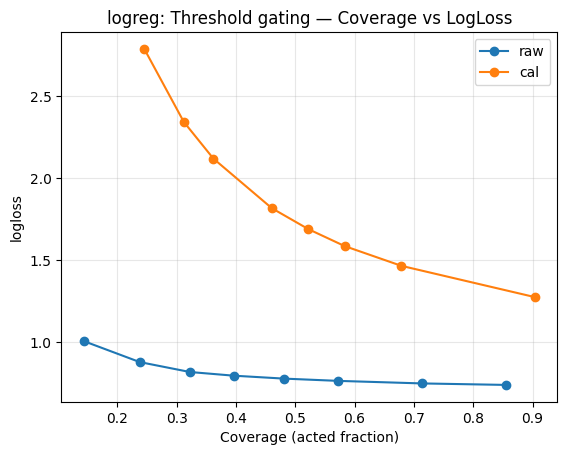

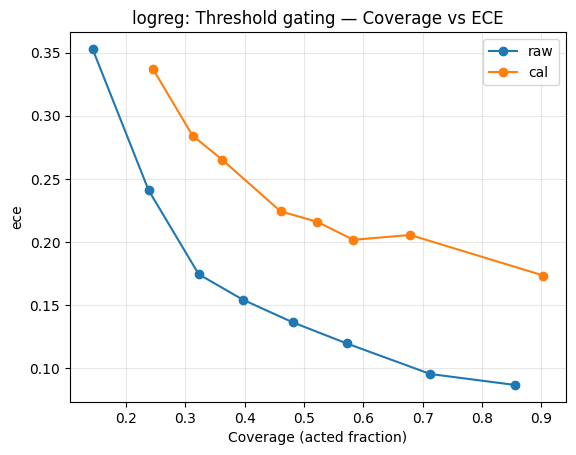

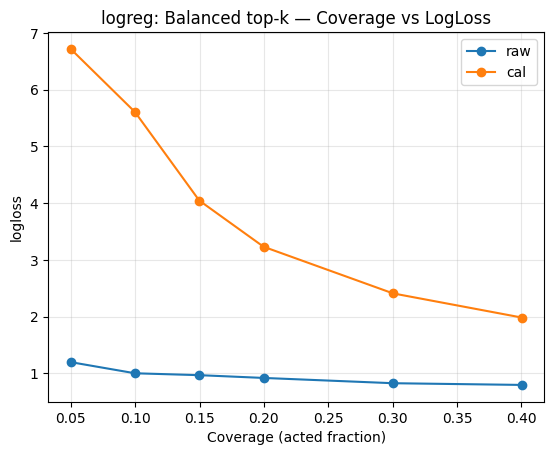

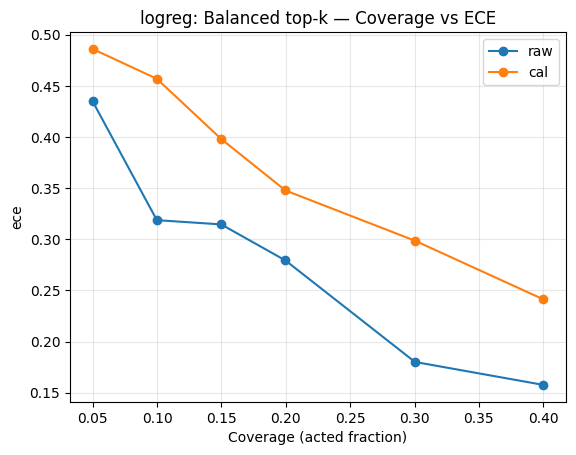

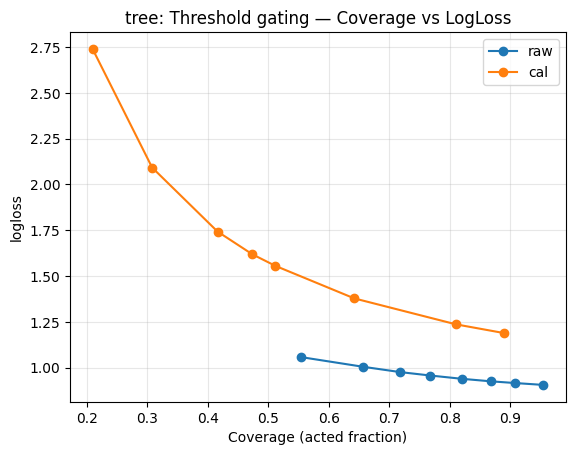

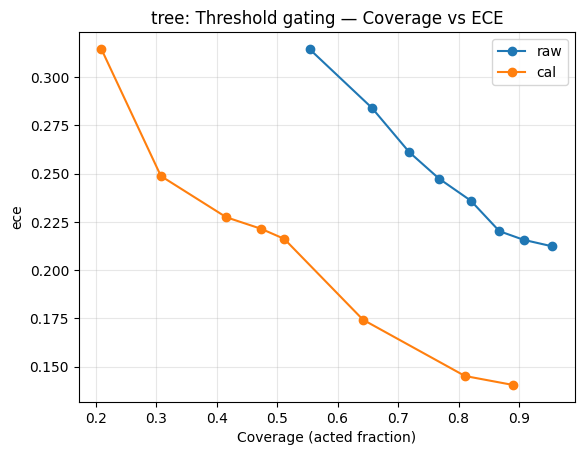

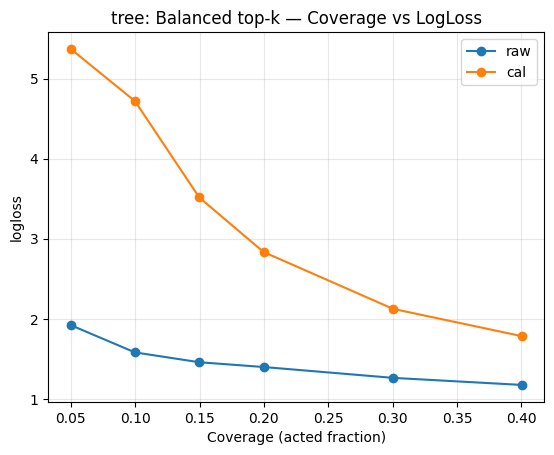

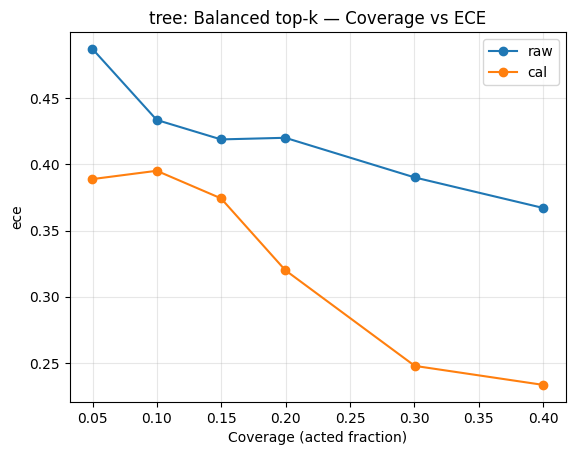

In [27]:
def plot_policy_tradeoff(df_pol: pd.DataFrame, model: str, policy: str, metric: str, title: str):
    plt.figure()
    sub = df_pol[(df_pol["model"] == model) & (df_pol["policy"] == policy)].copy()

    for variant in ["raw", "cal"]:
        g = sub[sub["variant"] == variant].copy()
        g = g.sort_values("coverage")
        plt.plot(g["coverage"], g[metric], marker="o", label=f"{variant}")

    plt.xlabel("Coverage (acted fraction)")
    plt.ylabel(metric)
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

for model in ["logreg", "tree"]:
    plot_policy_tradeoff(df_pol, model, "threshold", "logloss", f"{model}: Threshold gating — Coverage vs LogLoss")
    plot_policy_tradeoff(df_pol, model, "threshold", "ece", f"{model}: Threshold gating — Coverage vs ECE")
    plot_policy_tradeoff(df_pol, model, "balanced_topk", "logloss", f"{model}: Balanced top-k — Coverage vs LogLoss")
    plot_policy_tradeoff(df_pol, model, "balanced_topk", "ece", f"{model}: Balanced top-k — Coverage vs ECE")


## Interpretation

Expected behavior if calibration is beneficial:
- Overall logloss and Brier improve (decrease), especially for the tree model.
- Reliability curves move closer to the diagonal.
- ECE decreases at the operating coverages we care about (e.g., 20% balanced top-k).
- Directional accuracy may not change materially; calibration is about probability correctness.

If calibration helps only marginally for logreg, that is fine: logreg may already be near-calibrated.
If calibration materially improves tree probabilities, that supports using the tree as a second source of probabilistic information later (still without averaging).
